In [1]:
# The future
#from __future__ import print_function, division, absolute_import

# Data wrangling libraries
import pandas as pd
import numpy as np
import re
from io import StringIO

import matplotlib.pyplot as plt
import glob as glob
import pickle as pickle

# Numpy shorthand stuff
from numpy import array

# NLTK shorthand stuff
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import StanfordNERTagger
from nltk.tokenize import TweetTokenizer, RegexpTokenizer, sent_tokenize, word_tokenize
from nltk.tag import pos_tag

# SK-learn library for splitting data
from sklearn.model_selection import train_test_split


%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     /home/alexander_mpa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alexander_mpa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Borrowed some functions from the w266 utils.py file
# Miscellaneous helpers
def flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))


# Word processing functions
def canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
        #word = re.sub(r"(DG)+", "DG", word)
    return word


def canonicalize_word(word, wordset=None, digits=True):
    #word = re.sub(r":","",word)
    #word = re.sub(r"https?","",word)
    #word = re.sub(r"\/","",word)
    #word = re.sub(r"@","",word)
    #word = re.sub(r"/\U0001.?'","",word)
    #replace hyperlinks with one instance of "postedhyperlinkvalue"
    word = re.sub(r"(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S*", "postedhyperlinkvalue", word)
    word = re.sub(r"(postedhyperlinkvalue)+", "postedhyperlinkvalue", word)
    #only lower case words (2 letters or longer) that are not all upper case
    if not word.isupper() or len(word) == 1:
        word = word.lower()
    #replace things like haha with ha
    word = re.sub(r"([a-z]{2,})\1{2,}", r"\1", word)
    #replace any three consecutive, identical letters with two instances of that letter
    word = re.sub(r"([a-z])\1{2,}", r"\1\1", word)
    #replace any two consecutive, identical consonants at the beginning of a string with one of that consonant
    word = re.sub(r"(^[^aeiou])\1{1,}", r"\1", word)
    
    #replace digits with a stand-in token
    if digits:
        if (wordset != None) and (word in wordset): return word
        word = canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset):
        return word
    else:
        return constants.UNK_TOKEN

    
def canonicalize_words(words, **kw):
    return [canonicalize_word(word, **kw) for word in words]


# Made some helper functions of our own
from nltk.stem import PorterStemmer   
def stem_sentence(token_sent, stemmer=PorterStemmer()):
    stem_token_sent = []
    for word in token_sent:
        stem_token_sent.append(stemmer.stem(word))
    return stem_token_sent


def sent_plus_word_tokenize(series):
    sentences = []
    words = []
    
    for comment in series:
        sentences.append(sent_tokenize(comment))
    
    flat_sentences = [item for sublist in sentences for item in sublist]
    
    for comment_sentence in flat_sentences:
        words.append(word_tokenize(comment_sentence))
    
    return sentences, words


def make_data(data, target='', commentfield='', tokenizer=TweetTokenizer(), canonize=True, stem=True, nnp=True):      
    # Separate comments
    comments = data.loc[:, commentfield]
    #comments = data.loc[:, 'comment_body']
    #labels = data.loc[:, target]
    
    # Convert to list
    comment_list = comments.values.tolist()
    
    # Tokenize comments
    tokenizer = tokenizer
    # A list of lists of tokenized sentences: word == string/token; sentence == list of string/tokens
    tokenized_sentences = [tokenizer.tokenize(sentence) for sentence in comment_list]
    #tokenized_sentences_x = [tokenizer.tokenize(sentence) for sentence in comment_list]
    #tokenized_sentences = []
    #sentence = []
    #last_tok = ''
    #for comment in tokenized_sentences_x:
    #    for tok in comment:
    #        if last_tok in ('http', 'https',':','http:','https:','@'):
    #            tok = last_tok + tok
    #        if tok in ('http', 'https',':', '@'):
    #            last_tok = tok
    #        else:
    #            last_tok = ''
    #            sentence.append(tok)
    #    tokenized_sentences.append(sentence)
    
    if nnp:
        # Canonize proper nouns using stanford named entity recognizer
        comments_nnp = []
        
        #stanford ner tagger
        #st = StanfordNERTagger('../../../stanford_ner/stanford-ner-2018-02-27/classifiers/english.all.3class.distsim.crf.ser.gz',
        #                       '../../../stanford_ner/stanford-ner-2018-02-27/stanford-ner.jar',
        #                       encoding='utf-8')
        
        #nltk pos tagger -> pos_tag()
        
        for sentence in tokenized_sentences:
            #tagged_sent = st.tag(sentence)
            tagged_sent = pos_tag(sentence)
            cannonized_sent = []
            for i in tagged_sent:
                #if i[1] in ['PERSON', 'LOCATION', 'ORGANIZATION']:
                if i[1] == 'NNP':
                    cannonized_sent.append(i[1])
                else:
                    cannonized_sent.append(i[0])
                    
            comments_nnp.append(cannonized_sent)
        tokenized_sentences = comments_nnp
    
    if stem:
        # Stem words
        comments_stem = []
        for sentence in tokenized_sentences:
            x_tokens_stem = stem_sentence(token_sent=sentence, stemmer=PorterStemmer())
            comments_stem.append(x_tokens_stem)
        tokenized_sentences = comments_stem
    
    if canonize:
        # Canonize words
        comments_canon = []
        for sentence in tokenized_sentences:
            x_tokens_canon = canonicalize_words(sentence)
            comments_canon.append(x_tokens_canon)
        tokenized_sentences = comments_canon
    
    x_tokens = tokenized_sentences  
    #return comments, x_tokens, labels
    return comments, x_tokens


def rawlist_to_xtokens(rawlist=['default arg'], vocab_list=[]):
    xtokens = []
    for rawstring in rawlist:
        xtoken = list(filter(lambda x: x in vocab_list, rawstring.split()))
        xtokens.append(xtoken)   
    return xtokens


def xtoken_to_raw(xtoken=['default','arg']):  
    raw_text_string = ' '.join(xtoken)
    return raw_text_string


def raw_to_xtoken(raw_string='default arg'):
    xtoken = raw_string.split()
    return xtoken


def model_diagnostics(model, data, labels, target_names, random=False, test_size=0.10, random_state=42):
    
    # Split into test and train
    # Designate random test_size% of data (rounded up to next obs) as test data
    if random:
        train_data, test_data, train_labels, test_labels = train_test_split(data, labels, 
                                                                            test_size=test_size, 
                                                                            random_state=random_state)
    # Designate last test_size% of data (rounded up to next obs) as test data 
    else:
        idx = round(test_size*len(data))
        test_data = data[-idx:]
        test_labels = labels[-idx:]
    
    
    pred_labels = model.predict_classes(test_data)
    
    print("Test data length is: ", len(test_data))
    print("Test label length is: ", len(test_labels))
    print("Pred label length is: ", len(pred_labels))
    
    confusionMatrix = metrics.confusion_matrix(test_labels, pred_labels)
    classificationReport = classification_report(test_labels, pred_labels, target_names=target_names)
    
    return confusionMatrix, classificationReport


# Function to aggregate all of the comments for a given subreddit(s)

# Data location example: reddit data for March 2018 downloaded to ~/parlancr/data/reddit/2018_03/
# File names: reddit_2018_03000000000000.csv - reddit_2018_03000000000047.csv

def export_subreddits(subs):
    
    selected_subreddits = pd.DataFrame()
    file_stem = './data/reddit/*/reddit_*.csv'
    
    for f in sorted(glob.glob(file_stem)):
        
        print('Loading comments from: ', f)
        partition_comments = pd.read_csv(f)
        selected_subreddits = selected_subreddits.append(partition_comments[partition_comments['subreddit'].isin(subs)], ignore_index = True)
        
    return selected_subreddits


def build_model_input(pandas_df, commentfield, post_length, sent_length, tokenizer=TweetTokenizer()):
    
    comments, x_tokens = make_data(pandas_df, commentfield=commentfield, canonize=True, stem=False, tokenizer=tokenizer)
    
    tokens = [sent for sent in x_tokens if len(sent) <= sent_length]
    
    raw_list = list(map(xtoken_to_raw, tokens))
    
    pd_final = pd.DataFrame({commentfield:raw_list})
    
    return pd_final

## Load Data & Transform

In [ ]:
# Secondary set of wikipedia data, filtered to well-matched sentences from: (https://github.com/senisioi/NeuralTextSimplification)

# train set
wiki2_normal = pd.read_csv('data/train_normal_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])
wiki2_simple = pd.read_csv('data/train_simple_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])

print(wiki2_normal.head())
print(wiki2_normal.count())
print(wiki2_simple.head())
print(wiki2_simple.count())

wiki2_normal_model_input = build_model_input(pandas_df=wiki2_normal, commentfield='sentence_text', post_length=100, sent_length=1000)

print(wiki2_normal_model_input.head())
print(wiki2_normal_model_input.count())

wiki2_simple_model_input = build_model_input(pandas_df=wiki2_simple, commentfield='sentence_text', post_length=100, sent_length=1000)

print(wiki2_simple_model_input.head())
print(wiki2_simple_model_input.count())

wiki2_normal_model_input.to_csv('data/model_data/wiki_normal_matched_train.txt', sep='\t', index=False, header=False)
wiki2_simple_model_input.to_csv('data/model_data/wiki_simple_matched_train.txt', sep='\t', index=False, header=False)

In [ ]:
# dev set
wiki2_normal_dev = pd.read_csv('data/dev_normal_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])
wiki2_simple_dev = pd.read_csv('data/dev_simple_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])

wiki2_normal_model_input_dev = build_model_input(pandas_df=wiki2_normal_dev, commentfield='sentence_text', post_length=100, sent_length=1000)

wiki2_simple_model_input_dev = build_model_input(pandas_df=wiki2_simple_dev, commentfield='sentence_text', post_length=100, sent_length=1000)

wiki2_normal_model_input_dev.to_csv('data/model_data/wiki_normal_matched_dev.txt', sep='\t', index=False, header=False)
wiki2_simple_model_input_dev.to_csv('data/model_data/wiki_simple_matched_dev.txt', sep='\t', index=False, header=False)

In [ ]:
# test set
wiki2_normal_test = pd.read_csv('data/test_normal_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])
wiki2_simple_test = pd.read_csv('data/test_simple_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])

wiki2_normal_model_input_test = build_model_input(pandas_df=wiki2_normal_test, commentfield='sentence_text', post_length=100, sent_length=1000)

wiki2_simple_model_input_test = build_model_input(pandas_df=wiki2_simple_test, commentfield='sentence_text', post_length=100, sent_length=1000)

wiki2_normal_model_input_test.to_csv('data/model_data/wiki_normal_matched_test.txt', sep='\t', index=False, header=False)
wiki2_simple_model_input_test.to_csv('data/model_data/wiki_simple_matched_test.txt', sep='\t', index=False, header=False)

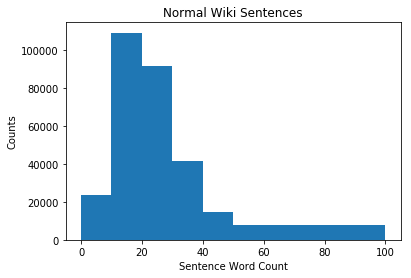

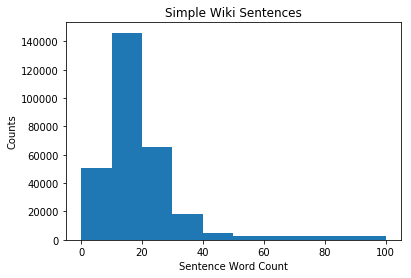

In [3]:
# looking at length of sentences

# train set
wiki2_normal_eda = pd.read_csv('data/model_data/wiki_normal_matched_train.txt', sep='\t', header = None, names = ['sentence_text'])
wiki2_simple_eda = pd.read_csv('data/model_data/wiki_simple_matched_train.txt', sep='\t', header = None, names = ['sentence_text'])

normal_lengths = []
normal_index = []
for i in wiki2_normal_eda['sentence_text']:
    normal_lengths.append(len(re.findall(r'\w+', i)))
    normal_index.append(len(re.findall(r'\w+', i)) <= 25)
    
simple_lengths = []
simple_index = []
for i in wiki2_simple_eda['sentence_text']:
    simple_lengths.append(len(re.findall(r'\w+', i)))
    simple_index.append(len(re.findall(r'\w+', i)) <= 25)

plt.figure(1)
plt.hist(normal_lengths, bins=[0, 10, 20, 30, 40, 50, 100])
plt.xlabel('Sentence Word Count')
plt.ylabel('Counts')
plt.title('Normal Wiki Sentences')


plt.figure(2)
plt.hist(simple_lengths, bins=[0, 10, 20, 30, 40, 50, 100])
plt.xlabel('Sentence Word Count')
plt.ylabel('Counts')
plt.title('Simple Wiki Sentences')

plt.show()

In [ ]:

# train set with long sentence filtering and pos/NER tokenization
wiki2_normal = pd.read_csv('data/train_normal_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])
wiki2_simple = pd.read_csv('data/train_simple_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])

print(wiki2_normal.count())
print(wiki2_simple.count())

wiki2_normal_model_input = build_model_input(pandas_df=wiki2_normal, commentfield='sentence_text', post_length=1000, sent_length=1000)

print(wiki2_normal_model_input.count())

wiki2_simple_model_input = build_model_input(pandas_df=wiki2_simple, commentfield='sentence_text', post_length=1000, sent_length=1000)

print(wiki2_simple_model_input.count())

normal_lengths = []
normal_index = []
for i in wiki2_normal_model_input['sentence_text']:
    normal_lengths.append(len(re.findall(r'\w+', i)))
    normal_index.append(len(re.findall(r'\w+', i)) <= 25)
    
simple_lengths = []
simple_index = []
for i in wiki2_simple_model_input['sentence_text']:
    simple_lengths.append(len(re.findall(r'\w+', i)))
    simple_index.append(len(re.findall(r'\w+', i)) <= 25)

wiki2_normal_model_input_short = wiki2_normal_model_input[normal_index]
wiki2_simple_model_input_short = wiki2_simple_model_input[normal_index]

print(wiki2_normal_model_input_short.count())
print(wiki2_simple_model_input_short.count())

wiki2_normal_model_input_short.to_csv('data/model_data/wiki_normal_matched_short_train.txt', sep='\t', index=False, header=False)
wiki2_simple_model_input_short.to_csv('data/model_data/wiki_simple_matched_short_train.txt', sep='\t', index=False, header=False)

In [ ]:
# dev set with long sentence filtering and pos/NER tokenization
wiki2_normal_dev = pd.read_csv('data/dev_normal_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])
wiki2_simple_dev = pd.read_csv('data/dev_simple_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])

#hack to fix mismatched sentences
wiki2_simple_dev = wiki2_simple_dev.append(pd.Series(wiki2_simple_dev['sentence_text'][15998]).to_frame(name = 'sentence_text'))

wiki2_normal_model_input_dev = build_model_input(pandas_df=wiki2_normal_dev, commentfield='sentence_text', post_length=1000, sent_length=1000)
wiki2_simple_model_input_dev = build_model_input(pandas_df=wiki2_simple_dev, commentfield='sentence_text', post_length=1000, sent_length=1000)

normal_lengths = []
normal_index = []
for i in wiki2_normal_model_input_dev['sentence_text']:
    normal_lengths.append(len(re.findall(r'\w+', i)))
    normal_index.append(len(re.findall(r'\w+', i)) <= 25)
    
simple_lengths = []
simple_index = []
for i in wiki2_simple_model_input_dev['sentence_text']:
    simple_lengths.append(len(re.findall(r'\w+', i)))
    simple_index.append(len(re.findall(r'\w+', i)) <= 25)

wiki2_normal_model_input_short_dev = wiki2_normal_model_input_dev[normal_index]
wiki2_simple_model_input_short_dev = wiki2_simple_model_input_dev[normal_index]

wiki2_normal_model_input_short_dev.to_csv('data/model_data/wiki_normal_matched_short_dev.txt', sep='\t', index=False, header=False)
wiki2_simple_model_input_short_dev.to_csv('data/model_data/wiki_simple_matched_short_dev.txt', sep='\t', index=False, header=False)

In [ ]:
# test set with long sentence filtering and pos/NER tokenization
wiki2_normal_test = pd.read_csv('data/test_normal_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])
wiki2_simple_test = pd.read_csv('data/test_simple_matched.txt', sep='\t', header = None, names = ['sentence_text']).dropna(subset=['sentence_text'])

wiki2_normal_model_input_test = build_model_input(pandas_df=wiki2_normal_test, commentfield='sentence_text', post_length=1000, sent_length=1000)
wiki2_simple_model_input_test = build_model_input(pandas_df=wiki2_simple_test, commentfield='sentence_text', post_length=1000, sent_length=1000)

normal_lengths = []
normal_index = []
for i in wiki2_normal_model_input_test['sentence_text']:
    normal_lengths.append(len(re.findall(r'\w+', i)))
    normal_index.append(len(re.findall(r'\w+', i)) <= 25)
    
simple_lengths = []
simple_index = []
for i in wiki2_simple_model_input_test['sentence_text']:
    simple_lengths.append(len(re.findall(r'\w+', i)))
    simple_index.append(len(re.findall(r'\w+', i)) <= 25)

wiki2_normal_model_input_short_test = wiki2_normal_model_input_test[normal_index]
wiki2_simple_model_input_short_test = wiki2_simple_model_input_test[normal_index]

print(wiki2_normal_model_input_short_test.count())
print(wiki2_simple_model_input_short_test.count())

wiki2_normal_model_input_short_test.to_csv('data/model_data/wiki_normal_matched_short_test.txt', sep='\t', index=False, header=False)
wiki2_simple_model_input_short_test.to_csv('data/model_data/wiki_simple_matched_short_test.txt', sep='\t', index=False, header=False)